In [ ]:
"""
|字段|含义|类型|
|:--:|:--:|
|interested_travel |旅行偏好|二分类|
|computer_owner |是否有家用电脑|二分类|
|age |估计的年龄|连续|
|home_value |房产价格|连续|
|loan_ratio|贷款比率|连续|
|risk_score |风险分数|连续|
|marital |婚姻状况估计|连续|
|interested_sport |运动偏好|连续|
|HH_grandparent|户主祖父母是否健在估计|连续|
|HH_dieting |户主节食偏好|连续|
|HH_head_age|户主年龄|连续|
|auto_member |驾驶俱乐部估计|连续|
|interested_golf |高尔夫偏好|二分类|
|interested_gambling |博彩偏好|二分类|
|HH_has_children |户主是否有孩子|二分类|
|HH_adults_num |家庭成年人数量|连续|
|interested_reading |阅读偏好|有序分类|

1、数据集中的变量较多，如果全部进入模型会导致模型解释困难。因此，一方面对于有相关性的变量进行降维，减少变量数目；
另一方面，基于业务理解，预先将变量进行分组，使得同一组的变量能尽量解释业务的一个方面。
比如本例中将变量分成三组，分别是家庭基本情况、财务状况和用户爱好，
通过对每组变量分别进行聚类，获取用户的侧写，再将三个聚类结果进行综合，以获得较完整的用户画像。

2、本例中数据类型复杂，包含了连续变量、无序分类和有序分类变量。
由于K-means仅用于连续型变量聚类，因此需要对变量进行预处理。
本例中由于有较多的二分类变量，又集中在用户爱好这一方面，因此将interested_reading这一有序分类变量二值化，再与其他几个二分类变量一起进行汇总，得到用户的“爱好广度”，使用“爱好广度”与其他连续型的爱好类变量进行聚类。
 
3、离散变量如HH_has_children不参与聚类，因为其本身就可以视作是簇的标签。
"""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(r'E:\大学\实习\简历\项目\旅游企业客户洞察')

In [3]:
travel = pd.read_csv("data_travel.csv")
travel.head()

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
0,NaN,NaN,64,124035,73,932,3,312,420,149,96,626,0,0,NaN,NaN,0
1,0.0,1.0,69,138574,73,1000,7,241,711,263,68,658,0,0,N,5.0,3
2,0.0,0.0,57,148136,77,688,1,367,240,240,56,354,0,1,N,2.0,1
3,1.0,1.0,80,162532,74,932,7,291,832,197,86,462,1,1,Y,2.0,3
4,1.0,1.0,48,133580,77,987,10,137,121,209,42,423,0,1,Y,3.0,3


In [4]:
travel.describe(include='all')

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
count,149788.000000,149788.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,167177.000000,159899,145906.000000,167177
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,3
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111462,NaN,65096
mean,0.427745,0.856571,59.507079,207621.314798,66.762707,817.031751,6.884015,259.431776,377.072498,204.593341,59.368023,486.861273,0.373012,0.357842,NaN,2.770832,NaN
std,0.494753,0.350511,14.311733,107822.501900,9.751835,165.490295,2.610552,78.867456,248.045395,78.971038,16.712912,151.167457,0.483607,0.479367,NaN,1.285417,NaN
min,0.000000,0.000000,18.000000,48910.000000,0.000000,1.000000,1.000000,60.000000,0.000000,47.000000,18.000000,49.000000,0.000000,0.000000,NaN,0.000000,NaN
25%,0.000000,1.000000,49.000000,135595.000000,63.000000,748.000000,5.000000,204.000000,182.000000,144.000000,48.000000,377.000000,0.000000,0.000000,NaN,2.000000,NaN
50%,0.000000,1.000000,59.000000,182106.000000,69.000000,844.000000,7.000000,251.000000,351.000000,185.000000,60.000000,492.000000,0.000000,0.000000,NaN,2.000000,NaN
75%,1.000000,1.000000,70.000000,248277.000000,73.000000,945.000000,9.000000,306.000000,528.000000,252.000000,71.000000,600.000000,1.000000,1.000000,NaN,4.000000,NaN


# 1.数据清洗

## 1.1 缺失值处理

In [5]:
#将各列缺失值进行计数，按照降序排列
missingTotal = travel.isnull().sum()
missingExist = missingTotal[missingTotal>0]
missingExist = missingExist.sort_values(ascending=False)
print(missingExist)

HH_adults_num        21271
computer_owner       17389
interested_travel    17389
HH_has_children       7278
dtype: int64


In [6]:
#含有缺失的变量皆为分类变量，且确实比例不高，选择用众数来填补
fill_cols = ['interested_travel','computer_owner','HH_adults_num']
fill_values = {col: travel[col].mode()[0] for col in fill_cols}
travel = travel.fillna(fill_values)

## 1.2 修正错误值

In [7]:
#查看变量中是否包含错误值
travel['interested_reading'].value_counts(dropna=False)

3    65096
1    43832
0    32919
2    24488
.      842
Name: interested_reading, dtype: int64

In [8]:
#阅读爱好（interested_reading）中包含错误值 "."，将其以0进行替换，代表该用户对于阅读没有兴趣
travel['interested_reading']=travel['interested_reading'].replace({'.':'0'}).astype('int')

## 1.3 对离散型变量进行处理

In [ ]:
"""
本例中由于有较多的二分类变量都集中在用户爱好这一方面，
因此将interested_reading这一有序分类变量二值化，再与其他几个二分类变量一起进行汇总，
得到用户的“爱好广度”，使用“爱好广度”与其他连续型的爱好类变量进行聚类。
"""

In [10]:
_cols = [
    'interested_travel',
    'computer_owner',
    'marital',
    'interested_golf', 
    'interested_gambling',
    'interested_reading'
]
#选择离散型变量时需要用卡方检验判断相关性，因为样本量过大，因此需要抽样检验，以避免因样本量而呈现显著的结果
sample = travel[_cols].sample(3000, random_state=12345)

In [11]:
#使用scipy中的统计检验函数进行离散变量的卡方检验
#将离散变量两两组合并计算每一组之间的p值，筛选出p值大于0.05的组
from itertools import combinations
from scipy import stats

for colA, colB in combinations(_cols, 2):
    crosstab = pd.crosstab(sample[colA],sample[colB])
    pval = stats.chi2_contingency(crosstab)[1]
    if pval > 0.05:
        print('p-value = %0.3f between "%s" and "%s"' %(pval, colA,colB))
#crosstab交叉表是用于统计分组频率的特殊透视表

In [12]:
#由上可知，变量之间都可以认为是相关的。这些相关的变量都是在表述“用户爱好”这一纬度
#将旅行、电脑、高尔夫、博彩、阅读这几个分类变量综合成一个“爱好广度”指标

In [13]:
#首先对interested_reading进行二值化
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=1.5)
travel['interested_reading']=binarizer.fit_transform(travel[['interested_reading']])

In [14]:
#生成爱好广度（interest）指标
interest =[
    'interested_travel',
    'computer_owner',
    'interested_golf', 
    'interested_gambling',
    'interested_reading'
]
n_=len(interest)
travel = travel.drop(interest, axis=1).assign(interest=travel[interest].sum(axis=1)/n_)

In [15]:
travel.head()

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,interest
0,64,124035,73,932,3,312,420,149,96,626,NaN,2.0,0.2
1,69,138574,73,1000,7,241,711,263,68,658,N,5.0,0.4
2,57,148136,77,688,1,367,240,240,56,354,N,2.0,0.2
3,80,162532,74,932,7,291,832,197,86,462,Y,2.0,1.0
4,48,133580,77,987,10,137,121,209,42,423,Y,3.0,0.8


## 1.4 正态化、标准化 

In [16]:
# - 对不同类型变量执行不同处理，连续变量、有序分类变量及无序分类变量在处理上均有不同，因此先按类型对变量分组，不同组采用不同的处理策略
# - 如果一个连续变量的可能取值很少，如marital（10个水平）、interest（5个水平）、HH_adults_num（8个水平）等，当将其作为普通连续变量一样进行分布转换，可能生成一些离群值（例如对marital使用scikit-learn进行正态转换，会发现1和10对应的数据点离开均值达到5个标准差）。因此本例中将这几个连续变量作为有序分类变量对待，但不进行分布转化，仅做标准化处理。

In [17]:
continuous_cols = ['age', 'home_value', 'risk_score', 'interested_sport', 
                   'HH_dieting', 'auto_member', 'HH_grandparent',
                   'HH_head_age', 'loan_ratio']

categorical_cols = ['marital', 'interest', 'HH_adults_num']

### 1.4.1 连续变量正态化 

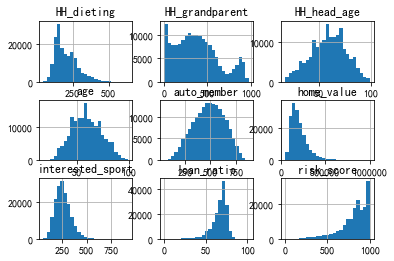

In [18]:
# 为了聚类后的簇大小比较接近，对于偏态严重的连续变量应转换其分布，令其接近正态分布或均匀分布
travel[continuous_cols].hist(bins=25)
plt.show()

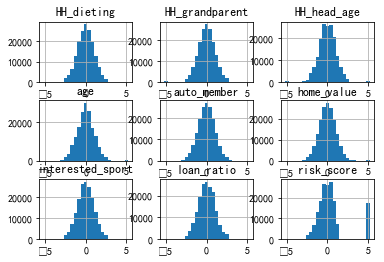

In [19]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
qt_data = qt.fit_transform(travel[continuous_cols])

pd.DataFrame(qt_data, columns=continuous_cols).hist(bins=25)
plt.show()

### 1.4.2 分类变量标准化

In [20]:
# 如前所述，尽管HH_adults_num、marital和interest属于连续变量，但都仅有不到10个水平，因此与有序分类变量一样，仅做标准化
from sklearn.preprocessing import scale
scale_data = scale(travel[categorical_cols])

In [21]:
data = np.hstack([qt_data, scale_data])
data = pd.DataFrame(data, columns=continuous_cols + categorical_cols)

## 1.5 连续变量筛选

In [22]:
#因为强相关的连续变量可能会造成聚类结果过于关注某个方面的信息，因此要首先查看相关系数矩阵
#查看相关系数矩阵,以0.6作为相关系数的上限
data_corr=data.corr()
data_corr[data_corr>0.6]
#在相关系数矩阵中,发现'age'和 'HH_head_age'的相关系数超过0.6，因此决定, 'HH_head_age'不参与聚类运算.

,age,home_value,risk_score,interested_sport,HH_dieting,auto_member,HH_grandparent,HH_head_age,loan_ratio,marital,interest,HH_adults_num
age,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,0.61019,NaN,NaN,NaN,NaN
home_value,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
risk_score,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interested_sport,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HH_dieting,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auto_member,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
HH_grandparent,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
HH_head_age,0.61019,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN
loan_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
marital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [23]:
#从两个宽泛的维度进行考虑，其一为用户家庭属性（家庭状况、财务状况）；其二为用户个人偏好情况
household = ['age', 'marital', 'HH_adults_num', 'HH_grandparent','home_value', 'risk_score', 'loan_ratio']
hobby = ['HH_dieting', 'auto_member', 'interest', 'interested_sport']

In [24]:
#先考虑用户家庭属性
#使用主成分分析确定保留多少个主成分合适
from sklearn.decomposition import PCA
pca_hh = PCA().fit(data[household])
pca_hh.explained_variance_ratio_.cumsum()

array([0.3773229 , 0.58399013, 0.75024846, 0.85836357, 0.9120415 ,
       0.95798458, 1.        ])

In [25]:
#对于家庭情况这一变量，保留4个主成分即可解释数据变异的83%，
#因此，因子分析中保留4个因子

In [26]:
from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting
fa_hh = FactorAnalysis.load_data_samples(
data [household],
preproc_demean=True,
preproc_scale=True
)
fa_hh.extract_components()
fa_hh.find_comps_to_retain(method='top_n',num_keep=4)

C:\ProgramData\Anaconda3\lib\site-packages\fa_kit\factor_analysis.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  np_data = df_data.as_matrix()


array([0, 1, 2, 3], dtype=int64)

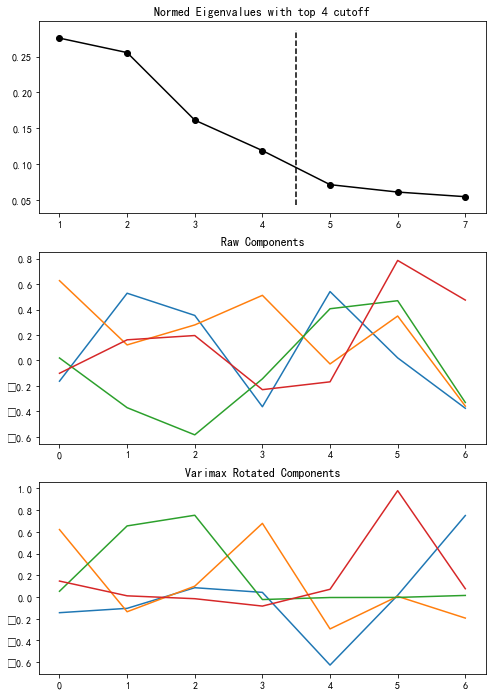

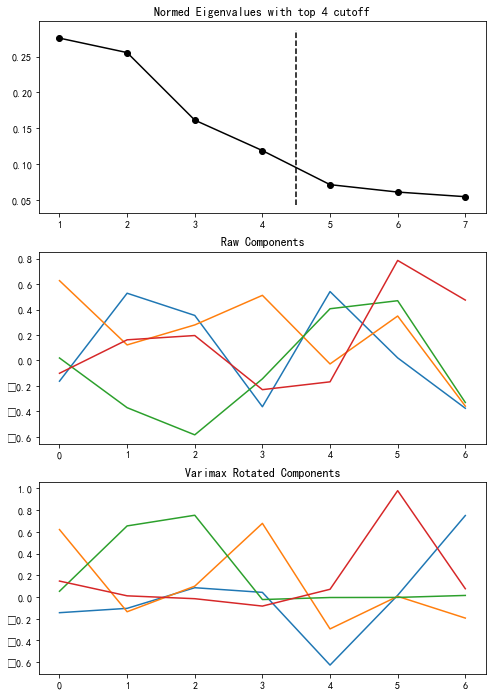

In [27]:
#通过最大方差法进行因子选装，将各个因子在7个变量上的载荷绘制出来
fa_hh.rotate_components(method='varimax')
fa_plotting.graph_summary(fa_hh)

In [28]:
pd.DataFrame(fa_hh.comps['rot'].T, columns=household)

,age,marital,HH_adults_num,HH_grandparent,home_value,risk_score,loan_ratio
0,-0.145486,-0.105414,0.084925,0.041921,-0.628658,0.015209,0.750539
1,0.621193,-0.136728,0.099082,0.678499,-0.295143,0.005182,-0.195219
2,0.052145,0.654902,0.753366,-0.024201,-0.005498,-0.004625,0.013685
3,0.146221,0.010063,-0.016426,-0.084564,0.070450,0.980018,0.075490


In [29]:
#由因子载荷矩阵中可以看到，
#第一个因子（蓝色线）在home_value,loan_ratio上的权重较高，主要表示用户财务状况
#第二个因子（黄色线）在age, HH_grandparent上的权重较高，主要表示用户所处的生命周期
#第三个因子（绿色线）在marital, HH_adults_num上的权重较高，主要表示为家庭的人口规模
#第四个隐私（红色线）在risk上的权重较高，主要表示用户的风险

In [30]:
#计算因子得分，并根据分析结果为每个因子命名
data_hh=pd.DataFrame(
np.dot(data[household],fa_hh.comps['rot']),
columns=['life_circle','finance','HH_size','risk'])
data_hh.head()

,life_circle,finance,HH_size,risk
0,1.166635,0.655741,-1.364915,0.586754
1,1.111304,1.443436,1.449475,5.064217
2,1.667202,-0.304142,-1.855966,-0.827276
3,0.680033,1.623557,-0.336755,0.715071
4,1.626156,-1.327853,0.986382,1.168544


In [31]:
#同理对用户的偏好属性进行因子分析
#使用主成分分析确定保留多少个主成分合适
from sklearn.decomposition import PCA
pca_hb = PCA().fit(data[hobby])
pca_hb.explained_variance_ratio_.cumsum()

array([0.48960613, 0.71584974, 0.91146228, 1.        ])

In [32]:
#对于用户偏好这一变量，保留3个主成分即可解释数据变异的91%，
#因此，因子分析中保留3个因子

In [33]:
from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting
fa_hb = FactorAnalysis.load_data_samples(
data [hobby],
preproc_demean=True,
preproc_scale=True
)
fa_hb.extract_components()
fa_hb.find_comps_to_retain(method='top_n',num_keep=3)

C:\ProgramData\Anaconda3\lib\site-packages\fa_kit\factor_analysis.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  np_data = df_data.as_matrix()


array([0, 1, 2], dtype=int64)

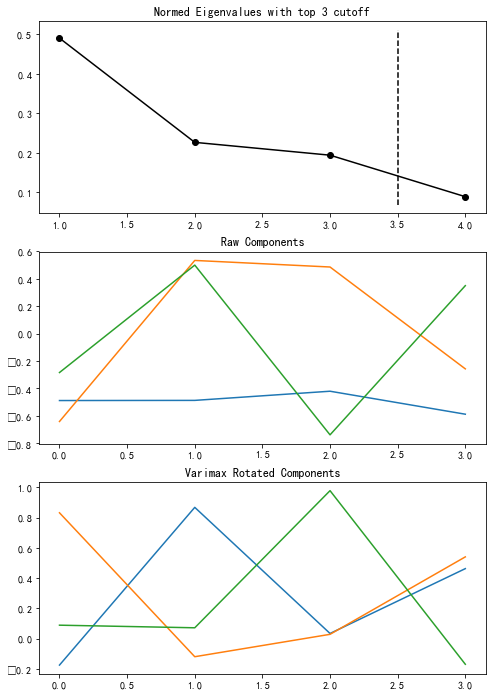

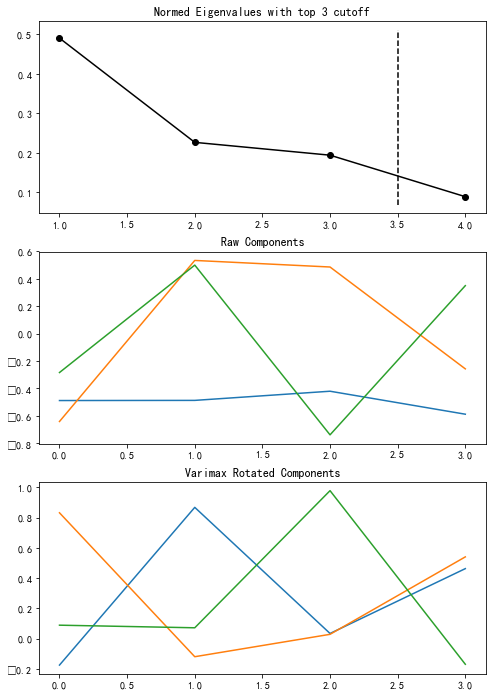

In [34]:
#通过最大方差法进行因子选装，将各个因子在4个变量上的载荷绘制出来
fa_hb.rotate_components(method='varimax')
fa_plotting.graph_summary(fa_hb)

In [35]:
pd.DataFrame(fa_hb.comps['rot'].T, columns=hobby)

,HH_dieting,auto_member,interest,interested_sport
0,-0.175836,0.868281,0.033374,0.462662
1,0.832272,-0.120477,0.027770,0.540405
2,0.088288,0.071068,0.978831,-0.170427


In [36]:
#由因子载荷矩阵中可以看到，
#第一个因子（蓝色线）在 auto_member, interested_sport上的权重较高，主要表示用户运动偏好
#第二个因子（黄色线）在 HH_dieting,interested_sport上的权重较高，主要表示用户健康偏好
#第三个因子（绿色线）在 interest上的权重较高，主要表示用户休闲娱乐偏好

In [37]:
#计算因子得分，并根据分析结果为每个因子命名
data_hb=pd.DataFrame(
np.dot(data[hobby],fa_hb.comps['rot']),
columns=['sports','health','leisure'])
data_hb.head()

,sports,health,leisure
0,1.136605,-0.159088,-1.125074
1,0.711412,0.469825,-0.174561
2,-0.223383,1.229133,-1.252986
3,0.113434,0.434238,1.562811
4,-1.202579,-0.716696,1.285169


# 2. 使用k-means聚类建模

## 2.1 k值的选择

In [38]:
#以下函数提供使用轮廓系数和簇内离差平方和探查合理聚类数量的功能
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_plot(data, k_range=range(2, 12), n_init=5, sample_size=2000, 
                 n_jobs=-1):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=n_init, n_jobs=n_jobs)
        kmeans.fit(data)
        sil = silhouette_score(data, kmeans.labels_, 
                               sample_size=sample_size)
        scores.append([k, kmeans.inertia_, sil])

    scores_df = pd.DataFrame(scores, columns=['k','sum_square_dist', 'sil'])
    plt.figure(figsize=[9, 2])
    plt.subplot(121, ylabel='sum_square')
    plt.plot(scores_df.k, scores_df.sum_square_dist)
    plt.subplot(122, ylabel='silhouette_score')
    plt.plot(scores_df.k, scores_df.sil)
    plt.show()

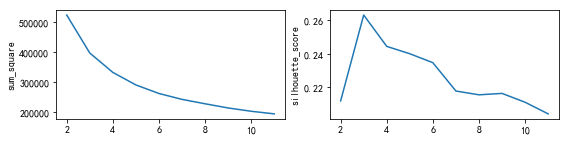

In [39]:
#因子得分需要进行标准化处理
scale_data_hh=scale(data_hh)
models_hh=cluster_plot(scale_data_hh)
models_hh

In [40]:
#k=3时，轮廓系数最高，但是k>3后簇内离差平方和的变化显著减缓
#因此用户家庭状况的分类k=4

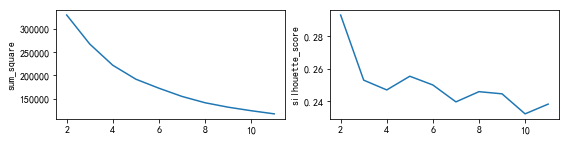

In [41]:
scale_data_hb=scale(data_hb)
models_hb=cluster_plot(scale_data_hb)
models_hb

In [42]:
#k=2时，轮廓系数最高，且k>2后轮廓系数下降较大
#因此用户偏好的分类k=2

## 2.2 聚类

In [43]:
#选择对应的k值对样本进行聚类并且添加对应的标签至原始数据集。
def k_means(data, k=2, n_init=5, n_jobs=-1):
    model = KMeans(n_clusters=k, n_init=n_init, n_jobs=n_jobs)
    model.fit(data)
    return model.labels_

household_labels = k_means(data_hh,k=4)
hobby_labels = k_means(data_hb, k=2)

label_names = ['Household', 'hobby']
labels = np.vstack([household_labels, hobby_labels]).T
travel_labels = travel.join(pd.DataFrame(labels, columns=label_names))

In [44]:
travel_labels[['Household','hobby']].head()

,Household,hobby
0,0,0
1,3,0
2,2,0
3,0,0
4,2,1


In [45]:
# 对各个簇的特征进行描述——使用原始数据
travel_labels.groupby('Household')[household].mean()

,age,marital,HH_adults_num,HH_grandparent,home_value,risk_score,loan_ratio
Household,,,,,,,
0,70.486454,6.406109,2.701672,606.254906,152466.929062,799.376373,68.062318
1,57.114854,8.830676,3.335760,251.803177,289983.738500,848.357618,60.131560
2,47.624243,5.474141,1.962950,243.657958,181076.834247,736.497811,72.890732
3,68.611859,6.475574,2.632291,467.655633,196746.622018,1000.000000,65.384888


In [46]:
travel_labels.groupby('hobby')[hobby].mean()

,HH_dieting,auto_member,interest,interested_sport
hobby,,,,
0,243.011676,571.704583,0.652047,307.637959
1,164.727582,398.821459,0.350970,209.409407


# 3. 对各个簇的特征进行描述

## 3.1 家庭属性聚类结果

In [49]:
from sklearn.tree import DecisionTreeClassifier

clf_hh = DecisionTreeClassifier()
clf_hb = DecisionTreeClassifier()

clf_hh.fit(travel_labels[household], travel_labels['Household'])
clf_hb.fit(travel_labels[hobby],travel_labels['hobby'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [59]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/Users/78416/graphviz-2.38/release/bin/'

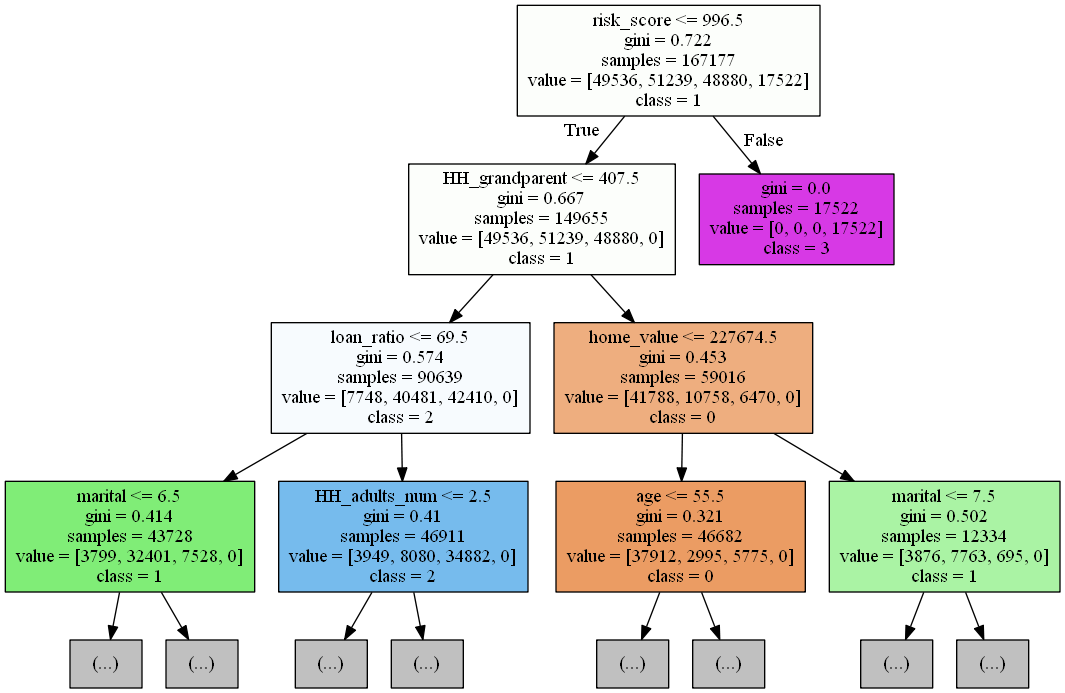

In [58]:
import pydotplus
from IPython.display import Image
import sklearn.tree as tree
dot_hh = tree.export_graphviz(
clf_hh,
out_file=None,
feature_names = household,
class_names=['0','1','2','3'],
max_depth=3,
filled=True)
graph_hh = pydotplus.graph_from_dot_data(dot_hh)
Image(graph_hh.create_png())

In [ ]:
"""
class0 = 低风险(risk score <= 996.5)、财务状况较差(homevalue <= 227674.5)、预测年龄较为年轻(age <= 55.5)
class1 = 低风险(risk score <= 996.5)、未婚(marital <= 7.5)、财务状况较好(homevalue > 227674.5)
class2 = 低风险(risk score <= 996.5)、负债较高(loan_ratio > 69.5)、家庭人数较少(HH_adults_num <= 2.5)
class3 = 高风险用户(risk score > 996.5)
"""

## 3.2 用户偏好属性聚类结果

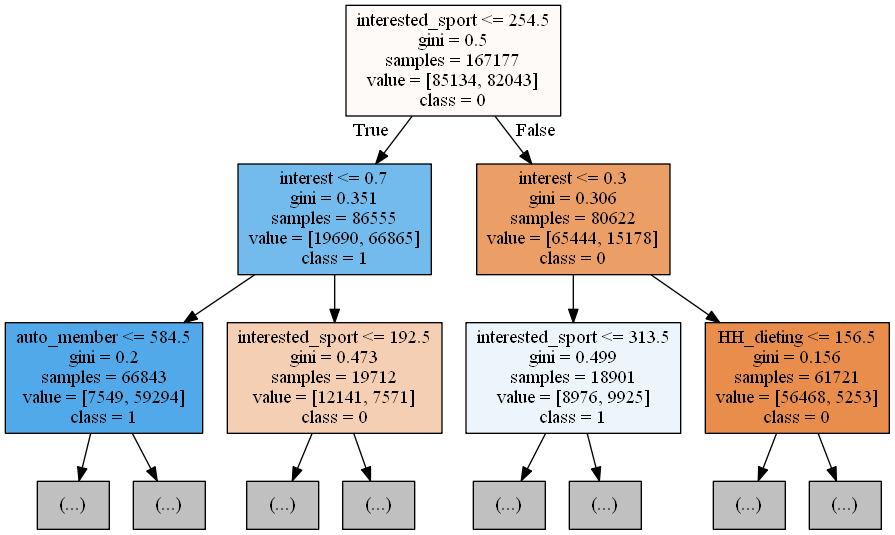

In [61]:
dot_hb = tree.export_graphviz(
clf_hb,
out_file=None,
feature_names = hobby,
class_names=['0','1'],
max_depth=2,
filled=True)
graph_hb = pydotplus.graph_from_dot_data(dot_hb)
Image(graph_hb.create_png())

In [ ]:
"""
class0 = 热爱运动（interested_sport > 254.5）、爱好广泛（interest > 0.3）、热爱健康（HH_dieting <= 156.5）
class1 = 不爱好运动（interested_sport <= 254.5）、爱好不广泛（interest <=0.7）
"""

In [ ]:
"""
营销策略建议：

对于家庭属性
第一类用户（class0）因其财务状况较差，但是风险比较低。可以推出更具有性价比的旅游项目，因为较为年轻，还可以主打个性化产品
第二类用户（class1）属于财务状况好，未婚低风险人群，可以推出高端高值旅游项目。
第三类用户（class2）负债较高，风险较低，可以实行分期付款、和推广性价比较高的旅游项目
第四类为高风险用户，应谨慎选择

对于用户偏好属性
第一类用户（class0）热爱运动、休闲等活动，对应的应推广更具有趣味性和个性化的项目
第二类用户（class1）因为其不热爱运动，爱好也不广泛，则可以推广以便利性为主的旅游项目

"""